# Overview

# Business Understanding

# Data Understanding

### Data source
The data used for this project was sourced from a dataset called ‘King County House Sales’ and contains information regarding housing sales statistics in King County, WA.

### The dataset contains the following columns:

id: A unique sale id relating to a house sale

date: Date of house sale

price: The price which the house sold for

bedrooms: How many bedrooms the house has

bathrooms: How many bathrooms the house has

sqft_living: How much square footage the house has

sqft_lot: How much square footage the lot has

floors: How many floors the house has

waterfront: Whether the house is on the waterfront. Originally contained ‘YES’ or ‘NO’, converted to 0 or 1 for comparative purposes

view: Whether the house has a view and whether it’s fair, average, good, or excellent. Converted to numberical (0-4) for comparative purposes

condition: overall condition of the house: Poor, Fair, Average, Good, Very Good

Grade: Numerical grading for house

sqft_above: How much of the houses square footage is above ground

sqft_basement: How much of the square footage is in the basement

yr_built: Year the house was built

yr_renovated: Year the house was renovated, if applicable

zipcode: House zipcode

lat: House’s latitude coordinate

long: House’s longitude coordinate

sqft_living15: Average size of living space for the closest 15 houses

sqft_lot15: Average size of lot for the closest 15 houses

# Data Cleaning

### Importing required modules

In [1]:
# Data manipulations
import pickle
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from itertools import combinations


#SKlearn
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Importing data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

### Processing cleaning

In [3]:
# Explore our data
display(df.head())
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
# Lets convert condition codes to numerical values for the prediction model
# Create function for conditional labeling:
def condition_coding (condition):
    """
    This will take the condition from string format and transform it into a corresponding code in integer format
    Poor = 1, Fair = 2, Average = 3, Good = 4, Very Good = 5
    """
    if condition == 'Poor':
        condition_code = 1
    elif condition == 'Fair':
        condition_code = 2
    elif condition == 'Average':
        condition_code = 3
    elif condition == 'Good':
        condition_code = 4
    elif condition == 'Very Good':
        condition_code = 5
    return condition_code

# Apply function to dataframe
df["condition_code"] = df['condition'].map(condition_coding)


In [5]:
# Lets convert grade codes to numerical values for the prediction model
# Create function for conditional labeling:
def grade_coding (grade):
    """
    This takes the grade in string format, splits it into a list of characters
    It then concatenates the first two characters from the list and strips the whitespace and turns the result into an integer
    We are left with a one or two digit integer correspondinng to the grade of the property
    """
    grade_list = list(grade)
    grade_code = int((grade_list[0] + grade_list[1]).strip())
    return grade_code

df['grade_code'] = df['grade'].map(grade_coding)

In [6]:
# Resolve missing values of house renovation dates. The column mode is 0, we fill missing values with it.
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [7]:
# Create house age feature.
# House age feature calculated the timeframe between transaction date and house construction date.
df['age'] = df["date"].map(lambda x: int(x[-4:])) - df['yr_built']


In [8]:
# Feature was house renovated or not. 
def renovated (year):
    """
    This returns a True / False value on whether a property has been renovated or not
    """
    if year == 0.0:
        return False
    elif year > 0.0:
        return True
    else:
        return False
    
df['renovated'] = df['yr_renovated'].map(renovated)

In [9]:
# The majority of values in waterfront column are - No. Fill the missing values with mode value if this column.
df['waterfront'] = df['waterfront'].fillna('NO')

# Convert waterfront column to numerical values for the prediction model 
df['waterfront_coded'] = df['waterfront'].map({'NO':0, 'YES':1})


In [10]:
# The majority of values in view column are - None. Fill the missing values with mode value if this column.
df['view'] = df['view'].fillna('NONE')

# Label view column for the prediction model.
df['view_coded'] = df['view'].map({'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4})


In [11]:
# Some values of sqft_basementa are missing. Find the missing values by subtracting sqft_above from sqft living.
df['sqft_basement'] = np.where(df['sqft_basement'] == '?', df['sqft_living'] - df['sqft_above'], df['sqft_basement'])
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [12]:
# Check the shape of finall dataframe without geo location data
df.shape

(21597, 27)

In [13]:
# location coordinates were scrapped from OSM in other jupyter notebook. 
# Load processed geo data from another notebook
with open('./data/Data_frame_geoloc.pickle', 'rb') as df_geo_data:
    df_geo = pickle.load(df_geo_data)


In [14]:
# Lets check size of dataframe, drop all dublicated columns.
df_geo.shape
df_geo.drop(['id', 'lat', 'price', 'yr_built', 'sqft_living', 'sqft_lot'], axis = 1 , inplace = True)


In [15]:
df_geo.shape

(21597, 8)

In [16]:
# Merge 2 dataframes and check all columns.
df = pd.concat([df,df_geo], axis =1, verify_integrity = True )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                21597 non-null  int64  
 1   date              21597 non-null  object 
 2   price             21597 non-null  float64
 3   bedrooms          21597 non-null  int64  
 4   bathrooms         21597 non-null  float64
 5   sqft_living       21597 non-null  int64  
 6   sqft_lot          21597 non-null  int64  
 7   floors            21597 non-null  float64
 8   waterfront        21597 non-null  object 
 9   view              21597 non-null  object 
 10  condition         21597 non-null  object 
 11  grade             21597 non-null  object 
 12  sqft_above        21597 non-null  int64  
 13  sqft_basement     21597 non-null  float64
 14  yr_built          21597 non-null  int64  
 15  yr_renovated      21597 non-null  float64
 16  zipcode           21597 non-null  int64 

In [17]:
# Investigate states and counties for noise.
print(df["state"].value_counts()) #all recods from Washington state
print(df["county"].value_counts()) # 4 records from different counties. 


Washington    21597
Name: state, dtype: int64
King County         21593
Pierce County           2
Snohomish County        2
Name: county, dtype: int64


In [18]:
#Remove records from other counties
df.drop(df[df.county != "King County"].index, inplace = True)
df.shape
#Drop county and state columns to reduce the number of features
df.drop("state", axis = 1, inplace = True)
df.drop("county", axis = 1, inplace = True)


In [19]:
df.shape

(21593, 33)

In [20]:
# Investigate "city" column for missing values
print(f"The number of records with missing cities {sum(df.city.isna())}") #779 records have no cities in it. 
print(f"Missing values are in {round(sum(df.city.isna())/df.shape[0]*100,2)} % of data")

The number of records with missing cities 779
Missing values are in 3.61 % of data


In [21]:
#Remove records with missing cities
df.drop(df[df.city.isna() == True].index, axis = 0, inplace = True)
df.shape

(20814, 33)

In [22]:
# Investigate "Type_place" column for missing values
print(f"The number of records with missing values {sum(df.Type_place.isna())}")

The number of records with missing values 0


In [23]:
# Investigate "suburb" column for missing values
print(f"The number of records with missing values {sum(df.suburb.isna())}")
print(f"Missing \"suburb\"values are in {round(sum(df.suburb.isna())/df.shape[0]*100,2)} % of data")
df_geo.suburb.value_counts() #There is no strong patterns in this data
print("Missing \"suburb\" values for cities are in ", round(sum(df[df.Type_place == "city"].suburb.value_counts())/df[df.Type_place == "city"].shape[0]*100,2), "% of records")
# We won't proceed with this data


The number of records with missing values 11942
Missing "suburb"values are in 57.37 % of data
Missing "suburb" values for cities are in  70.54 % of records


In [24]:
# Remove outliers in bedrooms
print(df.shape)
# Bedrooms have outliers, remove 1 of them
df.drop(df[(df.bedrooms == 33)].index, axis = 0, inplace = True)
df.drop(df[(df.bedrooms == 11)].index, axis = 0, inplace = True)
df.drop(df[(df.bedrooms == 10)].index, axis = 0, inplace = True)

print(df.shape)

(20814, 33)
(20809, 33)


In [25]:
# Drop all cathegorical values that were coverted to numerical
print(df.shape)
to_drop_cat = ["date", "waterfront", "view", "condition", "grade"]
df.drop(to_drop_cat, axis = 1, inplace = True)
print(df.shape)


(20809, 33)
(20809, 28)


In [26]:
#reset indexes
df_fin = df.reset_index().drop("index", axis = 1)

In [27]:
# Different type of geo columns
Geo_columns_basic_all = ["Type_place", "city"]
Geo_columns_basic_type = ["Type_place"]
Geo_columns_basic_city_names = ["city"]
Geo_columns_advanced = ["suburb"]
Geo_columns_drop = ["To_drop_place_ID", "To_drop_road"]

In [28]:
# Setup the type of geo columns that will be used for modelling
# Model one : encode each city into our dataframe
modeling_columns = Geo_columns_basic_city_names
Geo_columns_drop = [column for column in list(df_fin.columns) if ((column not in modeling_columns)  and (column != "id"))]

#seting up data categorical data for encoding !!!!!! (need to change later on)
X_cat_geo = df_fin.drop(Geo_columns_drop, axis = 1)


In [29]:
# setup One Hot Encoder 
encoder_geo_basic = OneHotEncoder(handle_unknown = "ignore")
fit_df = X_cat_geo.drop("id", axis = 1)
encoder_geo_basic.fit(fit_df)

OneHotEncoder(handle_unknown='ignore')

In [30]:
# Prepare transformed dataset
X_cat_transf=encoder_geo_basic.transform(fit_df)
X_geo_df = pd.DataFrame(X_cat_transf.todense(), columns = encoder_geo_basic.get_feature_names())
#X_geo_df["id"] = X_cat_geo["id"]
df_cities_columns = encoder_geo_basic.get_feature_names() # New added column names. If you need them later on.
df_cities = pd.concat([df_fin, X_geo_df], axis = 1)       # DF with coded cities/towns/villages


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
# Setup the type of geo columns that will be used for modelling
# Model two : encode only size of city into model
modeling_columns = Geo_columns_basic_type
Geo_columns_drop = [column for column in list(df_fin.columns) if ((column not in modeling_columns)  and (column != "id"))]

#seting up data categorical data for encoding !!!!!! (need to change later on)
X_cat_geo = df_fin.drop(Geo_columns_drop, axis = 1)


In [32]:
# setup One Hot Encoder 
encoder_geo_basic = OneHotEncoder(handle_unknown = "ignore")
fit_df = X_cat_geo.drop("id", axis = 1)
encoder_geo_basic.fit(fit_df)

OneHotEncoder(handle_unknown='ignore')

In [33]:
# Prepare transformed dataset
X_cat_transf=encoder_geo_basic.transform(fit_df)
X_geo_df = pd.DataFrame(X_cat_transf.todense(), columns = encoder_geo_basic.get_feature_names())
#X_geo_df["id"] = X_cat_geo["id"]
df_types_columns = encoder_geo_basic.get_feature_names() # New added column names. If you need them later on.
df_types = pd.concat([df_fin, X_geo_df], axis = 1)       # DF with coded cities/towns/villages
df_types

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,view_coded,lon,To_drop_place_ID,To_drop_road,Type_place,city,suburb,x0_city,x0_town,x0_village
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,...,0,-122.257,159583259.0,61st Avenue South,city,Seattle,NaN,1.0,0.0,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,...,0,-122.319,159668720.0,Northeast 127th Street,city,Seattle,Northgate,1.0,0.0,0.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,...,0,-122.233,74808506.0,81st Avenue Northeast,town,Kenmore,Moorlands,0.0,1.0,0.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,...,0,-122.393,156392831.0,Fauntleroy Way Southwest,city,Seattle,Fauntleroy,1.0,0.0,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,...,0,-122.045,293729110.0,221st Avenue Northeast,town,Sammamish,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,263000018,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,...,0,-122.346,20331941.0,North 97th Street,city,Seattle,Greenwood,1.0,0.0,0.0
20805,6600060120,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,...,0,-122.362,231509570.0,Southwest 103rd Place,city,Seattle,White Center,1.0,0.0,0.0
20806,1523300141,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,...,0,-122.299,157689516.0,26th Avenue South,city,Seattle,Leschi,1.0,0.0,0.0
20807,291310100,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,...,0,-122.069,293824524.0,Northwest Boulder Way Drive,town,Issaquah,NaN,0.0,1.0,0.0


In [34]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20809 entries, 0 to 20808
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          20809 non-null  int64  
 1   price                       20809 non-null  float64
 2   bedrooms                    20809 non-null  int64  
 3   bathrooms                   20809 non-null  float64
 4   sqft_living                 20809 non-null  int64  
 5   sqft_lot                    20809 non-null  int64  
 6   floors                      20809 non-null  float64
 7   sqft_above                  20809 non-null  int64  
 8   sqft_basement               20809 non-null  float64
 9   yr_built                    20809 non-null  int64  
 10  yr_renovated                20809 non-null  float64
 11  zipcode                     20809 non-null  int64  
 12  lat                         20809 non-null  float64
 13  long                        208

In [35]:
# Drob geo cathegorical columns that were transfered to numerical.
to_drop_index = [(number) for number, column in enumerate(df_cities.dtypes) if column == 'O']
to_drop_columns = list(df_cities.columns[to_drop_index])
df_cities = df_cities.drop(to_drop_columns, axis =1)

to_drop_index = [(number) for number, column in enumerate(df_types.dtypes) if column == 'O']
to_drop_columns = list(df_types.columns[to_drop_index])
df_types = df_types.drop(to_drop_columns, axis =1)



In [36]:
# Check columns left
df_cities.info()
df_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20809 entries, 0 to 20808
Data columns (total 72 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          20809 non-null  int64  
 1   price                       20809 non-null  float64
 2   bedrooms                    20809 non-null  int64  
 3   bathrooms                   20809 non-null  float64
 4   sqft_living                 20809 non-null  int64  
 5   sqft_lot                    20809 non-null  int64  
 6   floors                      20809 non-null  float64
 7   sqft_above                  20809 non-null  int64  
 8   sqft_basement               20809 non-null  float64
 9   yr_built                    20809 non-null  int64  
 10  yr_renovated                20809 non-null  float64
 11  zipcode                     20809 non-null  int64  
 12  lat                         20809 non-null  float64
 13  long                        208

In [37]:
#Final clean_up
final_drop = ["zipcode", "id", "zipcode", "lat", "long", "lon","To_drop_place_ID"]
df_cities = df_cities.drop(final_drop, axis = 1)
df_types = df_types.drop(final_drop, axis = 1)

In [38]:
# Output from data cleaning: 2 dataframes, cleaned from noise and with corrected data.
# df_cities - dataframe with encoded cities where property is located
# df_types - dataframe with encoded type of location (city, town or village)

df_cities
df_types
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20809 entries, 0 to 20808
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       20809 non-null  float64
 1   bedrooms                    20809 non-null  int64  
 2   bathrooms                   20809 non-null  float64
 3   sqft_living                 20809 non-null  int64  
 4   sqft_lot                    20809 non-null  int64  
 5   floors                      20809 non-null  float64
 6   sqft_above                  20809 non-null  int64  
 7   sqft_basement               20809 non-null  float64
 8   yr_built                    20809 non-null  int64  
 9   yr_renovated                20809 non-null  float64
 10  sqft_living15               20809 non-null  int64  
 11  sqft_lot15                  20809 non-null  int64  
 12  condition_code              20809 non-null  int64  
 13  grade_code                  208

# Data Modeling

1400    133
1300    132
1800    127
1440    125
1010    124
       ... 
6510      1
1463      1
5545      1
1982      1
1425      1
Name: sqft_living, Length: 1000, dtype: int64

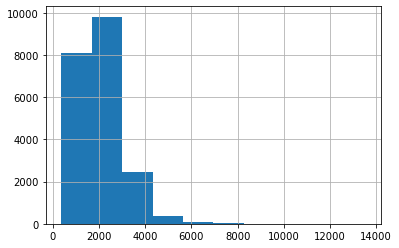

In [39]:
# Data transformation
df_cities["sqft_living"].hist()

df_cities["sqft_living"].value_counts()


In [40]:
from scipy.stats import kstest

kstest(df_cities["sqft_living"], 'norm')



KstestResult(statistic=1.0, pvalue=0.0)

In [41]:
kstest(np.log(df_cities["sqft_living"]), 'norm')


KstestResult(statistic=0.9999999983254629, pvalue=0.0)

<AxesSubplot:>

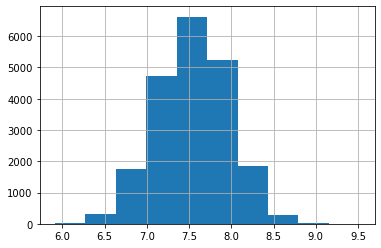

In [42]:
np.log(df_cities["sqft_living"]).hist()

In [43]:
linreg = LinearRegression()
linreg.fit(df_cities.drop("price", axis = 1), df_cities["price"])

y_hat = linreg.predict(df_cities.drop("price", axis = 1))
print(mean_squared_error(df_cities["price"],y_hat))
print(r2_score(df_cities["price"], y_hat))


31511996012.096645
0.7696982328178006


In [44]:
df_cities.iloc[0]

price                         221900.0
bedrooms                             3
bathrooms                          1.0
sqft_living                       1180
sqft_lot                          5650
                                ...   
x0_Tukwila                         0.0
x0_Union Hill-Novelty Hill         0.0
x0_Vashon                          0.0
x0_Woodinville                     0.0
x0_Yarrow Point                    0.0
Name: 0, Length: 66, dtype: object

In [45]:
# from sklearn.model_selection import cross_validate, cross_val_predict
# from sklearn.linear_model import SGDClassifier


# def linear_reg_calculator(Data, n = 1):
#     #model preparation
#     poly = PolynomialFeatures(n)
#     linreg = LinearRegression()
#     scoring_model = ["r2", "neg_mean_squared_error"]
#     kf = KFold(n_splits=5)
#     y = Data["price"]
#     X = Data.drop("price", axis = 1)
    
#     # Fit and transform X for polynomial function
#     X_poly= poly.fit_transform(X)
#     if n > 1:
#         X = X_poly
#     else:
#         pass
    
#     # Modelling
#     reg_poly = cross_validate(linreg, X, y, scoring= scoring_model, cv = kf)
#     mean = np.mean(reg_poly["test_r2"])
#     stand = np.std(reg_poly["test_r2"])
#     mean_mean_sq_error = -np.mean(reg_poly["test_neg_mean_squared_error"])
    
#     # Random house experiment
#     random_sample = np.random.random_integers(0, len(y))                 # Choose the random house from our prediction
#     y_hat = cross_val_predict(linreg, X, y, cv = kf)                     # Make predictions based on our model 
#     price = round(y[random_sample],0)                                    # sample house price
#     predicted_price = round(y_hat[random_sample], 0)                     # sample house predicted price
#     difference = round(100*(y_hat[random_sample]/y[random_sample]-1),2)  # difference between prices
    
#     #Outputs
#     print(f"Model accuracy based on R2 score {round(mean*100,1)}% with 95% conf interval +-{round(2*stand*100,1)}%")
#     print(f"Mean Squared Error {round(mean_mean_sq_error, 0)}")
#     print(f"Random house price {price}, predicted price {predicted_price}, difference {difference} %")
#     return mean_mean_sq_error, mean
    
# # Work example
# linear_reg_calculator(df_cities)

/var/folders/bg/b5dfn0gj1lz88k7ms283yrlm0000gn/T/ipykernel_12602/582838096.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 20809 + 1) instead
  random_sample = np.random.random_integers(0, len(y))                 # Choose the random house from our prediction


Model accuracy based on R2 score 75.9% with 95% conf interval +-3.8%
Mean Squared Error 32854038682.0
Random house price 730000.0, predicted price 860200.0, difference 17.84 %


(32854038681.78988, 0.758762951752512)

NameError: name 'columns' is not defined

In [ ]:
# # Explore Dropping different cathegories 
# columns = list(df_cities.columns)
# resultsss={}
# (MSE_base, accur_pred) = linear_reg_calculator(df_cities)

# for column in columns:
#     print(column)
#     if column != "price":
#         df_cities_cycle = df_cities
#         (MSE_drop, accur_drop) = linear_reg_calculator(df_cities_cycle.drop(column, axis=1))
#         change = accur_drop-accur_pred
#         resultsss[change] = column
#     else:
#         pass

# resultsss


In [ ]:
resultsss

In [52]:
df_types.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15', 'condition_code', 'grade_code', 'age',
       'renovated', 'waterfront_coded', 'view_coded', 'x0_city', 'x0_town',
       'x0_village'],
      dtype='object')

In [ ]:
# Explore polynomial features

In [62]:
df_cities_poly = df_cities

In [79]:
to_drop = ['sqft_basement', 'sqft_above', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15',"waterfront_coded", "view_coded", "bedrooms"]

In [81]:
df_cities2 = df_cities_poly.drop(df_cities_columns, axis = 1)
df_cities3 = df_cities2.drop(to_drop, axis = 1)


In [82]:
df_cities3

,price,bathrooms,sqft_living,sqft_lot,floors,condition_code,grade_code,age,renovated
0,221900.0,1.00,1180,5650,1.0,3,7,59,False
1,538000.0,2.25,2570,7242,2.0,3,7,63,True
2,180000.0,1.00,770,10000,1.0,3,6,82,False
3,604000.0,3.00,1960,5000,1.0,5,7,49,False
4,510000.0,2.00,1680,8080,1.0,3,8,28,False
...,...,...,...,...,...,...,...,...,...
20804,360000.0,2.50,1530,1131,3.0,3,8,5,False
20805,400000.0,2.50,2310,5813,2.0,3,8,1,False
20806,402101.0,0.75,1020,1350,2.0,3,7,5,False
20807,400000.0,2.50,1600,2388,2.0,3,8,11,False


In [85]:
linear_reg_calculator(df_cities3, 2)

Model accuracy based on R2 score 67.5% with 95% conf interval +-4.4%
Mean Squared Error 44496556246.0
Random house price 499950.0, predicted price 633037.0, difference 26.62 %


/var/folders/bg/b5dfn0gj1lz88k7ms283yrlm0000gn/T/ipykernel_12602/582838096.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 20809 + 1) instead
  random_sample = np.random.random_integers(0, len(y))                 # Choose the random house from our prediction


(44496556245.855316, 0.6749293914876725)

In [ ]:



list(df_cities.columns)

In [ ]:
# not so much variance :) 

In [86]:
df_cities

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,x0_SeaTac,x0_Seattle,x0_Shoreline,x0_Skykomish,x0_Snoqualmie,x0_Tukwila,x0_Union Hill-Novelty Hill,x0_Vashon,x0_Woodinville,x0_Yarrow Point
0,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1991.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20805,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20806,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20807,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
#model preparation
poly = PolynomialFeatures(2)
linreg = LinearRegression()
scoring_model = ["r2", "neg_mean_squared_error"]
kf = KFold(n_splits=5)
y = df_cities["price"]
X = df_cities.drop("price", axis = 1).drop(df_cities_columns, axis = 1).drop(to_drop, axis = 1)
X_poly= poly.fit_transform(X)
new_df = pd.concat([pd.DataFrame(X_poly), df_cities[df_cities_columns], df_cities["price"]], axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,x0_Seattle,x0_Shoreline,x0_Skykomish,x0_Snoqualmie,x0_Tukwila,x0_Union Hill-Novelty Hill,x0_Vashon,x0_Woodinville,x0_Yarrow Point,price
0,1.0,1.00,1180.0,5650.0,1.0,3.0,7.0,59.0,0.0,1.0000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221900.0
1,1.0,2.25,2570.0,7242.0,2.0,3.0,7.0,63.0,1.0,5.0625,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,538000.0
2,1.0,1.00,770.0,10000.0,1.0,3.0,6.0,82.0,0.0,1.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0
3,1.0,3.00,1960.0,5000.0,1.0,5.0,7.0,49.0,0.0,9.0000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,604000.0
4,1.0,2.00,1680.0,8080.0,1.0,3.0,8.0,28.0,0.0,4.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,1.0,2.50,1530.0,1131.0,3.0,3.0,8.0,5.0,0.0,6.2500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360000.0
20805,1.0,2.50,2310.0,5813.0,2.0,3.0,8.0,1.0,0.0,6.2500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400000.0
20806,1.0,0.75,1020.0,1350.0,2.0,3.0,7.0,5.0,0.0,0.5625,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,402101.0
20807,1.0,2.50,1600.0,2388.0,2.0,3.0,8.0,11.0,0.0,6.2500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400000.0


In [115]:
linear_reg_calculator(new_df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8

Model accuracy based on R2 score 77.1% with 95% conf interval +-4.7%
Mean Squared Error 31258468243.0
Random house price 309950.0, predicted price 329058.0, difference 6.16 %


/var/folders/bg/b5dfn0gj1lz88k7ms283yrlm0000gn/T/ipykernel_12602/582838096.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 20809 + 1) instead
  random_sample = np.random.random_integers(0, len(y))                 # Choose the random house from our prediction
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2

(31258468243.442406, 0.7711449486767528)

In [176]:
#model preparation
# poly = PolynomialFeatures(2)
# linreg = LinearRegression()
# scoring_model = ["r2", "neg_mean_squared_error"]
# kf = KFold(n_splits=5)
# y = df_cities["price"]
# X = df_cities.drop("price", axis = 1).drop(df_cities_columns, axis = 1).drop(to_drop, axis = 1)
# X_poly= poly.fit_transform(X)
# new_df = pd.concat([pd.DataFrame(X_poly), df_cities[df_cities_columns], df_cities["price"]], axis = 1)



from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

def linear_reg_calculator(Data, n = 1, to_drop = []):
    #model preparation
    poly = PolynomialFeatures(n)
    linreg = LinearRegression()
    scoring_model = ["r2", "neg_mean_squared_error"]
    kf = KFold(n_splits=5)
    y = Data["price"]
    X = Data.drop("price", axis = 1)    
    # execute code that will generate warnings
    # Fit and transform X for polynomial function
    if n > 1:
        X_new = X.drop(df_cities_columns, axis = 1)    # Drop geo categorical data
        if to_drop != []:
            X_new2 = X_new.drop(to_drop, axis = 1)     # Drop any additional columns we want
        else:
            pass
        X_poly= poly.fit_transform(X_new)                                        # Poly transformation on numerical data
        X = pd.concat([pd.DataFrame(X_poly), Data[df_cities_columns]], axis = 1) # Making new dataframe
    else:
        pass
    
    # Modelling
    reg_poly = cross_validate(linreg, X, y, scoring= scoring_model, cv = kf)
    mean = np.mean(reg_poly["test_r2"])
    stand = np.std(reg_poly["test_r2"])
    mean_mean_sq_error = -np.mean(reg_poly["test_neg_mean_squared_error"])
    
    # Random house experiment
    difference_list=[]
    random_sample = np.random.randint(0, len(y))                         # Choose the random house from our prediction
    y_hat = cross_val_predict(linreg, X, y, cv = kf)                     # Make predictions based on our model 
    price = round(y[random_sample],0)                                    # sample house price
    predicted_price = round(y_hat[random_sample], 0)                     # sample house predicted price
    difference = round(100*(y_hat[random_sample]/y[random_sample]-1),2)  # difference between prices
    
    # Random 20 houses prediction
    for i in list(range(20)):
        random_sample = np.random.randint(0, len(y))
        difference_list.append(round(100*(y_hat[random_sample]/y[random_sample]-1),2))
    difference_mean = round(np.mean(difference_list),2)    
        
    
    #Outputs
    print(f"Model accuracy based on R2 score {round(mean*100,1)}% with 95% conf interval +-{round(2*stand*100,1)}%")
    print(f"Mean Squared Error {round(mean_mean_sq_error, 0)}")
    print(f"Random house price {price}, predicted price {predicted_price}, difference {difference} %")
    print(f"Sample(20 houses) prediction price difference {difference_mean} %")
    return mean_mean_sq_error, mean
    
# Work example
linear_reg_calculator(df_cities, 2)

Model accuracy based on R2 score 81.8% with 95% conf interval +-2.7%
Mean Squared Error 24849794196.0
Random house price 590000.0, predicted price 511028.0, difference -13.39 %
Sample(20 houses) prediction price difference 3.74 %


(24849794195.848194, 0.8175665424714997)

In [161]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Regression Results

# Conclusion